## Time-Series Representation

### Load package

In [22]:
using CSV, DataFrames
using Statistics
using Plots
using Clustering
using Random

### Load data

In [23]:
# time-series data
loads = CSV.read(joinpath("..","data","NordicBaltic","load.csv"),DataFrame)
winds = CSV.read(joinpath("..","data","NordicBaltic","wind.csv"),DataFrame)
offshores = CSV.read(joinpath("..","data","NordicBaltic","wind_offshore.csv"),DataFrame)
pvs = CSV.read(joinpath("..","data","NordicBaltic","pv.csv"),DataFrame)
rors = CSV.read(joinpath("..","data","NordicBaltic","ror.csv"),DataFrame)
reservoirs = CSV.read(joinpath("..","data","NordicBaltic","reservoir.csv"),DataFrame)
ts_dicts = Dict(
    "load"=>loads,
    "wind"=>winds,
    "pv"=>pvs,
    "ror"=>rors,
    "offshore"=>offshores,
    "reservoir"=>reservoirs,
)

# network data
nodes = CSV.read(joinpath("..","data","NordicBaltic","nodes.csv"),DataFrame)

7×6 DataFrame
 Row │ id     name       v_nom  longitude  latitude  area  
     │ Int64  String15   Int64  Float64    Float64   Int64 
─────┼─────────────────────────────────────────────────────
   1 │     1  Denmark      380    10.1805   55.6601      1
   2 │     2  Estonia      380    25.9342   58.7472      2
   3 │     3  Finland      380    26.3944   62.0538      1
   4 │     4  Latvia       380    25.9562   57.0921      2
   5 │     5  Lithuania    380    23.9365   54.4277      2
   6 │     6  Sweden       380    14.8453   56.1738      1
   7 │     7  Norway       380     8.4689   60.472       1

### Remove date and rename column to node ids

In [24]:
for df in values(ts_dicts)
    select!(df, Not(:t))
    rename!(df, string.(nodes.id))
end

### Plot the load for each country.

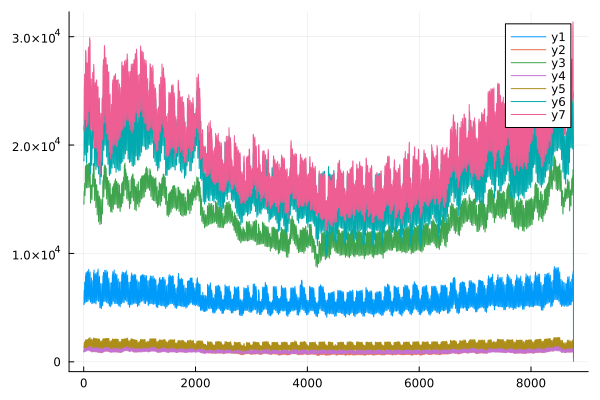

In [25]:
plt = plot()
for i in nodes.id
    plot!(plt,ts_dicts["load"][:,i])
end
plt

### Hour 8760 seems corrupted, so remove it.

In [26]:
for key in keys(ts_dicts)
    ts_dicts[key] = ts_dicts[key][1:end-1,:]
end

### Plot the load for each country again.

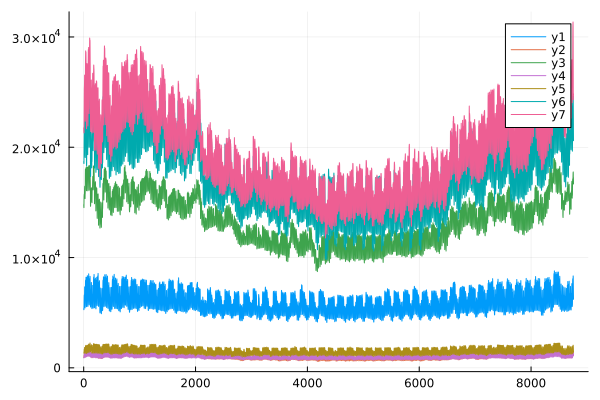

In [27]:
plt = plot()
for i in nodes.id
    plot!(plt,ts_dicts["load"][:,i])
end
plt

In [28]:
plt = Dict()
for key in keys(ts_dicts)
    if key != "load"
        plt[key] = plot(title=key, titlefontsize=10)
    else
        plt[key] = plot(title="load (GW)", titlefontsize=10)
    end
    for (i,node) in zip(1:7,nodes.name)
        if key == "pv"
            plot!(plt[key], ts_dicts[key][:,"$i"], label=node)
        elseif key == "load"
            plot!(plt[key], ts_dicts[key][:,"$i"]./1000, label=:none)
        else
            plot!(plt[key], ts_dicts[key][:,"$i"], label=:none)
        end
    end
end
plot([value for value in values(plt)]...,layout=(6,1))
plot!(size=(700,1200))
ts_dicts_plot = plot!(legend=:topright)
savefig(ts_dicts_plot,joinpath("..","figs","raw_time_series.png"))

"/Users/rahimi/Codes/MEng-thesis/figs/raw_time_series.png"

In [29]:
ldcs = plot()
for (i,node) in zip(1:7,nodes.name)
    plot!(ldcs, sort(ts_dicts["load"][:,"$i"][1:end-1]./1000,rev=true), linewidth=3, label=node, xlabel="hour",ylabel="load (GW)")
end
ldcs
savefig(ldcs,joinpath("..","figs","ldcs.png"))

"/Users/rahimi/Codes/MEng-thesis/figs/ldcs.png"

### Helper function: getKRepresentativePeriods()

In [30]:
function getKRepresentativePeriods(ts_dicts,nodes;k=100,norm="zscore",seed=910)
    
    # dictionary to concatenated array
    ts_data = hcat(Array.(collect(values(ts_dicts)))...)
    ts_df = DataFrame()
    
    # zscore or minmax normalisation
    if norm=="zscore"
        ts_data_norm = (ts_data .- mean(ts_data,dims=1)) ./ std(ts_data,dims=1)
    elseif norm=="minmax"
        ts_data_norm = (ts_data .- minimum(ts_data,dims=1)) ./ 
            (maximum(ts_data,dims=1) .- minimum(ts_data,dims=1))
    else
        ts_data_norm = ts_data
    end
    ts_data_norm[isinf.(ts_data_norm)] .= 0
    ts_data_norm[isnan.(ts_data_norm)] .= 0

    # seed for reproducibility
    Random.seed!(seed)
    clusters = kmeans(ts_data_norm',k)
    
    # prepare column names
    colnames = []
    for key in keys(ts_dicts)
        for node in nodes.id
            push!(colnames,"$key$node")
        end
    end

    # denormalise and get DataFrame
    if norm=="zscore"
        ts_df = DataFrame(
            Array(clusters.centers') .* std(ts_data,dims=1) .+ 
            mean(ts_data,dims=1),colnames)
        ts_df[!,:w] = counts(clusters)
    elseif norm=="minmax"
        ts_df = DataFrame(
            Array(clusters.centers') .* (maximum(ts_data,dims=1) .- minimum(ts_data,dims=1)) .+ 
            minimum(ts_data,dims=1),colnames)
        ts_df[!,:w] = counts(clusters)
    else
        ts_df = Array(clusters.centers')
    end
    ts_df
end          

getKRepresentativePeriods (generic function with 1 method)

### Helper function: getDurationCurve()

In [31]:
function getDurationCurve(ts_df;node="Norway",type="load")
    idx = nodes[nodes.name.==node,:id][1]
    ts_node = sort(select(ts_df,r""*type*"")[:,"$type$idx"],rev=true)
    steps = []
    step_hours = []
    cumulative_hours = 0
    for i in 1:length(ts_node)
        push!(steps, ts_node[i])
        cumulative_hours += sort(ts_df,type*"$idx",rev=true)[i,:w]
        push!(step_hours, cumulative_hours)
    end
    step_hours, steps
end

getDurationCurve (generic function with 1 method)

### Helper function: getAllNodeNRMSE()

In [32]:
function getAllNodeNRMSE(ts_dicts,nodes;k=100,norm="zscore",type="load",seed=910)
    ts_df = getKRepresentativePeriods(ts_dicts,nodes,k=k,norm=norm,seed=seed)
    se = 0
    total = 0
    for node in nodes.name
        step_hours, steps = getDurationCurve(ts_df;node=node,type=type)
        idx = nodes[nodes.name.==node,:id][1]
        se = se + sum((sort(ts_dicts[type][:,"$idx"],rev=true)[step_hours].- steps).^2)
        total = total + length(step_hours)
    end
    (sqrt(se/total))/(maximum(Array(ts_dicts[type])) - minimum(Array(ts_dicts[type])))
end

getAllNodeNRMSE (generic function with 1 method)

### Hyperparameter tuning (k, norm) -> set NRMSE threshold to 0.02

$\begin{align}
    &k\in \{5,10,...,45,50\} \\
    &norm\in \{"zscore","minmax"\}
\end{align}$

In [33]:
hp_tuning = Dict()
for key in keys(ts_dicts)
    hp_tuning[key] = Dict("k"=>[],"zscore"=>[],"minmax"=>[])
end
for k in 10:5:100
    for (key,value) in pairs(hp_tuning)
        push!(value["k"],k)
        for norm in ["zscore","minmax"]
            nrmse = getAllNodeNRMSE(ts_dicts,nodes;k=k,norm=norm,type=key,seed=910)
            push!(value[norm],nrmse)
        end
    end
end
hp_tuning

Dict{Any, Any} with 6 entries:
  "pv"        => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…
  "offshore"  => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…
  "ror"       => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…
  "reservoir" => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…
  "load"      => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…
  "wind"      => Dict{String, Vector{Any}}("k"=>[10, 15, 20, 25, 30, 35, 40, 45…

### Visualise result

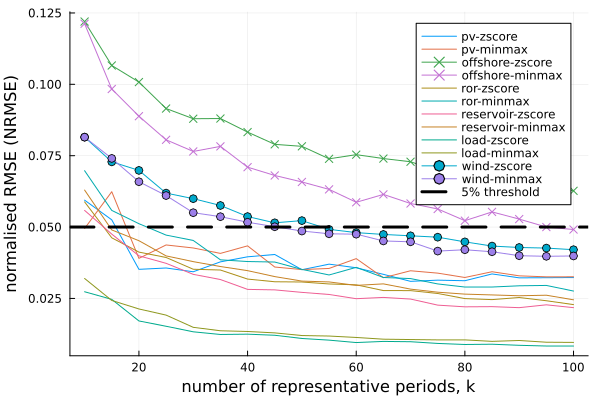

In [34]:
plt = plot()
for key in keys(hp_tuning)
    for norm in ["zscore","minmax"]
        if (key != "offshore") & (key != "wind")
            plot!(plt, hp_tuning[key]["k"],hp_tuning[key][norm],label="$key-$norm")
        elseif key != "wind"
            plot!(plt, hp_tuning[key]["k"],hp_tuning[key][norm],marker=:x,label="$key-$norm")
        else
            plot!(plt, hp_tuning[key]["k"],hp_tuning[key][norm],marker=:o,label="$key-$norm")
        end
    end
end
plot!(xlabel="number of representative periods, k",ylabel="normalised RMSE (NRMSE)")
hline!([0.05],linestyle=:dash, linecolor=:black, linewidth=3, label = "5% threshold")
display(plt)

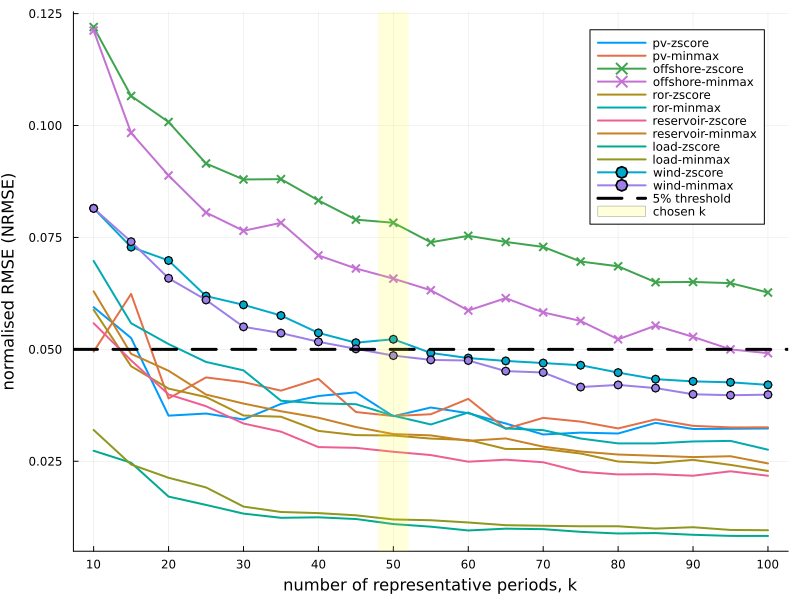

"/Users/rahimi/Codes/MEng-thesis/figs/hp_tuning_results.png"

In [35]:
hp_plt = plot()
for key in keys(hp_tuning)
    for norm in ["zscore","minmax"]
        if (key != "offshore") & (key != "wind")
            plot!(hp_plt, hp_tuning[key]["k"],hp_tuning[key][norm],label="$key-$norm",linewidth=2)
        elseif key != "wind"
            plot!(hp_plt, hp_tuning[key]["k"],hp_tuning[key][norm],marker=:x,label="$key-$norm",linewidth=2)
        else
            plot!(hp_plt, hp_tuning[key]["k"],hp_tuning[key][norm],marker=:o,label="$key-$norm",linewidth=2)
        end
    end
end
plot!(xlabel="number of representative periods, k",ylabel="normalised RMSE (NRMSE)")
plot!(xticks=10:10:100, size=(800,600))
hline!([0.05],linestyle=:dash, linecolor=:black, linewidth=3, label = "5% threshold")
vspan!([48, 52]; alpha = 0.15,color=:yellow, label="chosen k")
display(hp_plt)
savefig(hp_plt,joinpath("..","figs","hp_tuning_results.png"))

In [36]:
DataFrame(hp_tuning["wind"])

19×3 DataFrame
 Row │ k    minmax     zscore    
     │ Any  Any        Any       
─────┼───────────────────────────
   1 │ 10   0.0814905  0.0815029
   2 │ 15   0.0740479  0.0728396
   3 │ 20   0.0658786  0.0698506
   4 │ 25   0.0610346  0.0618906
   5 │ 30   0.0550318  0.059943
   6 │ 35   0.0536353  0.0575566
   7 │ 40   0.0516853  0.053674
   8 │ 45   0.0501113  0.0514864
  ⋮  │  ⋮       ⋮          ⋮
  13 │ 70   0.0448367  0.0469391
  14 │ 75   0.0415838  0.0464525
  15 │ 80   0.0420545  0.0448077
  16 │ 85   0.0413508  0.0433414
  17 │ 90   0.0399638  0.0428471
  18 │ 95   0.0397564  0.0426366
  19 │ 100  0.0398762  0.0420697
                   4 rows omitted

### k = 50, norm = minmax

In [37]:
reduced_forecast = getKRepresentativePeriods(ts_dicts,nodes,k=50,norm="minmax",seed=910);

### Adjust for extreme peak load conditions

Norway example

In [38]:
step_hours, steps = getDurationCurve(reduced_forecast;node="Norway",type="load")
plot(sort(ts_dicts["load"][!,"$(nodes[nodes.name.=="Norway",:id][1])"]./1000,rev=true),label="raw", linewidth=2)
# plot!(step_hours, steps,label="k=40",linetype=:steppre)
plot!(vcat(0,step_hours), vcat(steps[1],steps)./1000,label="k=50",linetype=:steppre, linewidth=2)
plt = plot!(ylabel="load (GW)", xlabel="hour")
savefig(plt,joinpath("..","figs","LDCnoAdj.png"))



"/Users/rahimi/Codes/MEng-thesis/figs/LDCnoAdj.png"

We can see that extreme peak load conditions are not represented

### Scale top and bottom to match peak and through demand

### Helper function: getAdjustedRepresentativePeriods()

In [39]:
function getAdjustedKRepresentativePeriods(ts_dicts,nodes;k=120,norm="minmax",seed=910,scale=0.01)
    data = getKRepresentativePeriods(ts_dicts,nodes,k=k,norm=norm,seed=seed)
    for node in nodes.id
        data = sort(data,"load$node",rev=true)
        # scale top
        data[1:Int(round(scale*k)),"load$node"] = 
            maximum(sort(loads[:,"$node"],rev=true))/maximum(data[:,"load$node"]) .*
            data[1:Int(round(scale*k)),"load$node"]
        # scale bottom
        # data[end+1-Int(round(scale*k)):end,"load$node"] = 
        #     minimum(sort(loads[:,"$node"],rev=true))/minimum(data[:,"load$node"]) .*
        #     data[end+1-Int(round(scale*k)):end,"load$node"]
    end
    data
end

getAdjustedKRepresentativePeriods (generic function with 1 method)

### Example: scaling the top 1%

In [40]:
adjusted_forecast = 
    getAdjustedKRepresentativePeriods(ts_dicts,nodes;k=40,norm="minmax",seed=910,scale=0.02)
adj_step_hours, adj_steps = getDurationCurve(adjusted_forecast;node="Norway",type="load")
plot(sort(ts_dicts["load"][!,"$(nodes[nodes.name.=="Norway",:id][1])"]./1000,rev=true),label="raw", linewidth=2)
# plot!(adj_step_hours, adj_steps,label="k=40 adj. 2.5%", linetype=:steppre)
plot!(vcat(0,adj_step_hours), vcat(adj_steps[1],adj_steps)./1000,label="k=50 adj. 2%",linetype=:steppre, linewidth=2)
plt = plot!(ylabel="load (GW)", xlabel="hour")
savefig(plt,joinpath("..","figs","LDCAdj.png"))

"/Users/rahimi/Codes/MEng-thesis/figs/LDCAdj.png"

### Example: scaling the top 2%

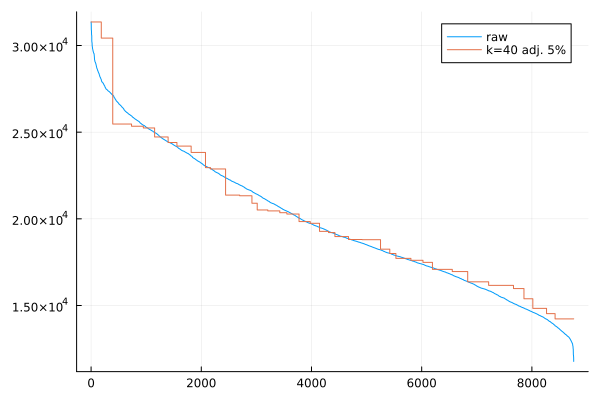

In [41]:
adjusted_forecast_2 = 
    getAdjustedKRepresentativePeriods(ts_dicts,nodes;k=40,norm="minmax",seed=910,scale=0.05)
adj_step_hours_2, adj_steps_2 = getDurationCurve(adjusted_forecast_2;node="Norway",type="load")
plot(sort(ts_dicts["load"][!,"$(nodes[nodes.name.=="Norway",:id][1])"],rev=true),label="raw")
# plot!(adj_step_hours_2, adj_steps_2,label="k=40 adj. 5%", linetype=:steppre)
plot!(vcat(0,adj_step_hours_2), vcat(adj_steps_2[1],adj_steps_2),label="k=40 adj. 5%",linetype=:steppre)

### Test for 1,2,3,4,5 %

### Helper function: getAdjustedAllNodeNRMSE()

In [42]:
function getAdjustedAllNodeNRMSE(
    nodes,loads,ts_dicts;k=50,norm="zscore",type="load",seed=910,scale=0.01)
    ts_df = getAdjustedKRepresentativePeriods(ts_dicts,nodes,k=k,norm=norm,seed=seed,scale=scale)
    se = 0
    total = 0
    for node in nodes.name
        step_hours, steps = getDurationCurve(ts_df;node=node,type=type)
        idx = nodes[nodes.name.==node,:id][1]
        se = se + sum((sort(ts_dicts[type][:,"$idx"],rev=true)[step_hours].- steps).^2)
        total = total + length(step_hours)
    end
    (sqrt(se/total))/(maximum(Array(ts_dicts[type])) - minimum(Array(ts_dicts[type])))
end

getAdjustedAllNodeNRMSE (generic function with 1 method)

In [43]:
hp_scale_result = Dict("scale"=>[],"nrmse"=>[])
for scale in 0.00:0.02:0.1
    push!(hp_scale_result["scale"],scale)
    nrmse = getAdjustedAllNodeNRMSE(
                nodes,loads,ts_dicts;k=50,norm="minmax",type="load",seed=910,scale=scale)
    push!(hp_scale_result["nrmse"],nrmse)
end
hp_scale_df = DataFrame(hp_scale_result)

6×2 DataFrame
 Row │ nrmse      scale 
     │ Any        Any   
─────┼──────────────────
   1 │ 0.0119991  0.0
   2 │ 0.0133504  0.02
   3 │ 0.0158685  0.04
   4 │ 0.0174471  0.06
   5 │ 0.0193426  0.08
   6 │ 0.0212695  0.1

Thus, we scale the top 1%

### In hindsight, k=10 for faster computation

In [44]:
adjusted_representative_periods = getAdjustedKRepresentativePeriods(
        ts_dicts, nodes; k=10, norm="minmax", seed=910, scale=0.02 
)
first(adjusted_representative_periods,5)

5×43 DataFrame
 Row │ pv1        pv2        pv3        pv4        pv5        pv6        pv7   ⋯
     │ Float64    Float64    Float64    Float64    Float64    Float64    Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0582573  0.0580034  0.0429195  0.0616535  0.0664415  0.0565149  0.066 ⋯
   2 │ 0.0552265  0.0379214  0.0315984  0.0419369  0.0460815  0.0403163  0.051
   3 │ 0.0708663  0.0442113  0.0392227  0.0535516  0.0640307  0.0531153  0.054
   4 │ 0.035627   0.0322112  0.0315971  0.0298766  0.0299118  0.0320896  0.034
   5 │ 0.508058   0.535373   0.515401   0.516711   0.504202   0.519713   0.457 ⋯
                                                              37 columns omitted

In [45]:
last(adjusted_representative_periods,5)

5×43 DataFrame
 Row │ pv1         pv2        pv3        pv4        pv5        pv6        pv7  ⋯
     │ Float64     Float64    Float64    Float64    Float64    Float64    Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.425821    0.393351   0.384205   0.384445   0.40127    0.405191   0.38 ⋯
   2 │ 0.314177    0.311116   0.308086   0.306749   0.323626   0.307955   0.28
   3 │ 0.0119022   0.0129652  0.0118595  0.012127   0.0130151  0.0128596  0.01
   4 │ 0.0164172   0.0164806  0.0188646  0.0165511  0.0168716  0.0173558  0.01
   5 │ 0.00849376  0.0109067  0.0130091  0.0104225  0.0101505  0.0103368  0.01 ⋯
                                                              37 columns omitted

### See the distributions

### Example: Norway load distribution

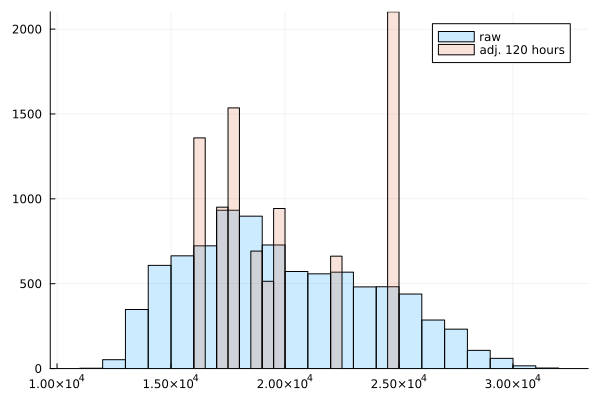

In [46]:
histogram(loads[:,"$(nodes[nodes.name.=="Norway",:id][1])"], fillalpha=.2, nbins=20, label="raw")
histogram!(adjusted_representative_periods[:,"load$(nodes[nodes.name.=="Norway",:id][1])"],weights=adjusted_representative_periods[:,:w], fillalpha=.2, nbins=20, label="adj. 120 hours")

### Example: Norway wind distribution

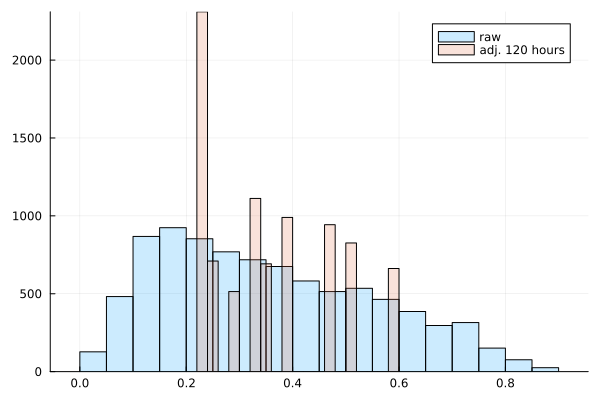

In [47]:
histogram(winds[:,"$(nodes[nodes.name.=="Norway",:id][1])"], fillalpha=.2, nbins=20, label="raw")
histogram!(adjusted_representative_periods[:,"wind$(nodes[nodes.name.=="Norway",:id][1])"],weights=adjusted_representative_periods[:,:w], fillalpha=.2, nbins=20, label="adj. 120 hours")

### Example: Norway offshore distribution


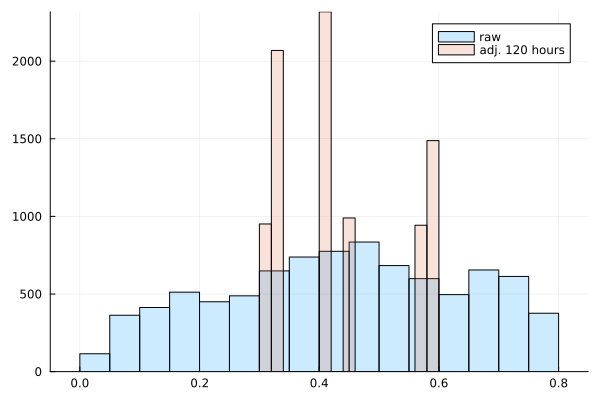

In [48]:
histogram(offshores[:,"$(nodes[nodes.name.=="Norway",:id][1])"], fillalpha=.2, nbins=20, label="raw")
histogram!(adjusted_representative_periods[:,"offshore$(nodes[nodes.name.=="Norway",:id][1])"],weights=adjusted_representative_periods[:,:w], fillalpha=.2, nbins=20, label="adj. 120 hours")

### Example: Norway pv distribution

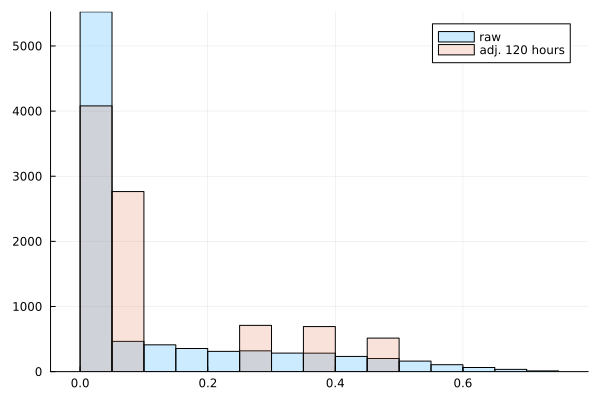

In [49]:
histogram(pvs[:,"$(nodes[nodes.name.=="Norway",:id][1])"], fillalpha=.2, nbins=20, label="raw")
histogram!(adjusted_representative_periods[:,"pv$(nodes[nodes.name.=="Norway",:id][1])"],weights=adjusted_representative_periods[:,:w], fillalpha=.2, nbins=20, label="adj. 120 hours")

### Export to csv file

In [50]:
adjusted_representative_periods.id = 1:size(adjusted_representative_periods)[1]
adjusted_representative_periods = select(adjusted_representative_periods,:id,Not(:id))
CSV.write(
    joinpath("..","data","NordicBaltic","periods.csv"),
    adjusted_representative_periods
)

"../data/NordicBaltic/periods.csv"